# Example of a Convolutional Neural Network (Multilabel) for Text Classification

In [1]:
!pip install nltk

Processing ./.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266/nltk-3.5-py3-none-any.whl
  Using cached regex-2020.5.14-cp37-cp37m-manylinux2010_x86_64.whl (675 kB)


In [2]:
!conda install pytorch torchvision cudatoolkit=10.0 -c pytorch --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cudatoolkit=10.0
    - pytorch
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    certifi-2020.4.5.1         |   py37hc8dfbb8_0         151 KB  conda-forge
    cudatoolkit-10.0.130       |                0       261.2 MB  defaults
    intel-openmp-2020.1        |              217         780 KB  defaults
    mkl-2020.1                 |              217       129.0 MB  defaults
    ninja-1.10.0               |       hc9558a2_0         1.9 MB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 

In [1]:
#Imports needed from pytorch
import torch
from torch.utils.data import Dataset
from collections import OrderedDict


#Some built-in imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
from os.path import join, isfile
from os import listdir

#Imports from the repository
from data_processing import get_weight_matrix, get_tokens
import data_processing as dp
from privacy_policies_dataset import PrivacyPoliciesDataset as PPD
from cnn import CNN

In [2]:
current_attribute = "Action Third-Party"
current_num_levels = 5

If this is not the first time you run the code and you are using the same embeddings and the same dataset then you can skip several cells and just run cell 5 to load the weights matrix, cell 7 to load labels and cell 10 to load datasets. Once you have run these cells you can jump straight into section 3 and run the CNN.

In [3]:
def confusion_matrices(model, dataset, threshold):
    
    metrics = {}
    x = PPD.collate_data(dataset)[0]
    y_hat  = model(x)
    """ge = greater equal than threshold"""
    y_hat = torch.ge(y_hat, threshold).double() #predicted
    y = dataset.labels_tensor.double()  #actual
    tp = (y * y_hat).sum(0).numpy()
    tn = ((1 - y) * (1 - y_hat)).sum(0).numpy()
    fp = (y_hat * (1 - y)).sum(0).numpy()
    fn = ((1 - y_hat) * y).sum(0).numpy()
    metrics['TP'] = tp
    metrics['TN'] = tn
    metrics['FP'] = fp
    metrics['FN'] = fn
    
    return metrics

def confusion_matrices_change(metrics_05, metrics_best_t):
    
    labels = range(current_num_levels)
    fig = plt.figure(figsize=(15,10))
    fig.suptitle("metrics differences")
    tp_ax = fig.add_subplot(221)
    tn_ax = fig.add_subplot(222)
    fp_ax = fig.add_subplot(223)
    fn_ax = fig.add_subplot(224)
    
    tp_ax.plot(labels, metrics_05['TP'], label = 't = 0.5')
    tn_ax.plot(labels, metrics_05['TN'], label = 't = 0.5')
    fp_ax.plot(labels, metrics_05['FP'], label = 't = 0.5')
    fn_ax.plot(labels, metrics_05['FN'], label = 't = 0.5')
    
    tp_ax.set_ylabel('TP')
    tn_ax.set_ylabel('TN')
    fp_ax.set_ylabel('FP')
    fn_ax.set_ylabel('FN')
    
    tp_ax.plot(labels, metrics_best_t['TP'], label = 'best t')
    tn_ax.plot(labels, metrics_best_t['TN'], label = 'best t')
    fp_ax.plot(labels, metrics_best_t['FP'], label = 'best t')
    fn_ax.plot(labels, metrics_best_t['FN'], label = 'best t')
    
    tp_ax.legend()
    tn_ax.legend()
    fp_ax.legend()
    fn_ax.legend()
    
    plt.show()

## 1. Generating word embeddings matrix

We read from raw_data all the files and get all the different words we can find within all the files. If we already have a file named dictionary.pkl and read set to True, it will read the dictionary from this file. 

In [4]:
dictionary = get_tokens(f"{current_attribute}", f"embeddings_data/attr", read = False)

Processing dataset ...


The next step is to load the pretrained embeddings. We will get two python dictionaries. Both have the words as the keys of the python dictionaries and one has the vectors as the keys whilst the other one has the position on the dictionary.

In [5]:
fast_text_model = 'fastText-0.1.0/corpus_vectors_default_300d/WOW_MEGA_PP.vec'

word2vector_fast_text = dp.get_fast_text_dicts(fast_text_model, "embeddings_data", 100, missing = False, read = False)

Processing dataset ...


In [6]:
# word2vector_glove = dp.get_glove_dicts( "data",  "glove.6B", "embeddings_data/attr", 300, read = True)

# print("Number of words in the pretrained embeddings: {}".format(len(word2vector_glove)))

Now we compute the matrix containing all the word embeddings that we will need for the embedding layer of the CNN and 
we obtain a word2idx of just all the words inside dictionary and not all the words present in the word embeddings. Usually the pretrained embeddings that we will use have more words than what we need, that is the reason why we need to obtain a new word2idx of just all the words that we found in the files inside train and test folders.

`get_weigth_matrix()` variables:
1. dimensions
2. folder
3. read
4. oov_random
5. kwargs: dictionary, word2vector

In [7]:
#weights_matrix = get_weight_matrix(300, "embeddings_data", read = True)
#weights_matrix = get_weight_matrix(300, "embeddings_data", oov_random = False, dictionary = dictionary, word2vector = word2vector_glove)
weights_matrix = get_weight_matrix(100, "embeddings_data/attr", read = False, oov_random = False, dictionary = dictionary, word2vector = word2vector_fast_text)

Processing dataset ...
dims 100
Some words were missing in the word2vector. 114 words were not found.


In [8]:
weights_matrix

array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [-0.17572 , -0.13731 , -0.18353 , ...,  0.050218,  0.20277 ,
         0.072381],
       [ 0.090629, -0.17127 ,  0.087155, ..., -0.19708 ,  0.069763,
         0.22564 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

### 2. Creation of Datasets

The first step before obtaining the prefectly cleaned data that will be used in the CNN is to aggregate the labels. The raw_data folder provides a series of files in csv format with repeated sentences. The reason behind this is that some sentences have several labels assigned to them. The last step is to aggregate segments and obtain a list of labels per sentence. The following function gets all the data from raw_data folder and outputs the result in agg_data.

In [9]:
# labels = OrderedDict([('Children', 0),
#              ('Californians', 1),
#              ('Citizens from other countries', 2),
#              ('Europeans', 3)])
labels = dp.attr_value_labels(current_attribute)
# dp.aggregate_data_attribute_level(current_attribute, current_num_levels, read=False)
dp.aggregate_data(f"{current_attribute}", current_attribute, current_num_levels, read = False)

Processing dataset in one file ...
                          label  \
0     [0.0, 0.0, 0.0, 0.0, 1.0]   
1     [0.0, 0.0, 0.0, 0.0, 1.0]   
2     [0.0, 1.0, 0.0, 0.0, 0.0]   
3     [0.0, 1.0, 0.0, 0.0, 0.0]   
4     [0.0, 1.0, 0.0, 0.0, 0.0]   
...                         ...   
2455  [0.0, 1.0, 0.0, 0.0, 0.0]   
2456  [0.0, 1.0, 0.0, 0.0, 0.0]   
2457  [0.0, 1.0, 0.0, 0.0, 0.0]   
2458  [0.0, 1.0, 0.0, 0.0, 0.0]   
2459  [0.0, 1.0, 0.0, 0.0, 0.0]   

                                                segment  
0                        Disclosure of your information  
1        Links to third party web sites and advertisers  
2     transmitted to other users of the Websites usi...  
3                            are posted and transmitted  
4                                              to share  
...                                                 ...  
2455  We employ other companies and individuals as a...  
2456  Whenever we share personal information with ou...  
2457  if you choose to

In [10]:
labels_file = open(f"labels_{current_attribute}.pkl","rb")

labels = pickle.load(labels_file)

labels_file.close()

for label, index in labels.items():
    
    print(str(index) + '. ' + label)

0. Collect on first party website/app
1. Receive/Shared with
2. See
3. Track on first party website/app
4. Unspecified


Now that we have the aggregated data in agg_data we will process all the sentences and transform them into a list of integers. The integers will refer to the position inside the word2idx dictionary. The labels will also be transformed into an n-dimensinal vector with 1s if a sentence has that label and 0s if it doesn't. All the data will be placed in the corresponding folder inside processed_data. We load the labels with which we want to perform the classification. We will also show them so that it is clearer to the user.

In [11]:
# sentence_matrices_all, labels_matrices_all = dp.process_attribute_level_dataset(dictionary, current_attribute, read = False)
sentence_matrices_all, labels_matrices_all = dp.process_dataset(labels, dictionary, current_attribute, read = False)

Processing dataset ...
Num of unique segments segments: 2460


We now create an PPD which stands for PrivacyPoliciesDataset containing the training and testing dataset. We will need to split the data in two to get the test training data and the data that will be used for training and validation. The function split_dataset_randomly is spliting the dataset 90/10 by default.

In [12]:
dataset = PPD(sentence_matrices_all, labels_matrices_all, labels)

test_dataset, train_validation_dataset = dataset.split_dataset_randomly(0.2)

validation_dataset, train_dataset = train_validation_dataset.split_dataset_randomly(0.2)

test_dataset.pickle_dataset(f"datasets/test_dataset_{current_attribute}_attr.pkl")

train_dataset.pickle_dataset(f"datasets/train_dataset_{current_attribute}_attr.pkl")

validation_dataset.pickle_dataset(f"datasets/validation_dataset_{current_attribute}_attr.pkl")

/home/jovyan/privacy_policies_dataset.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels_tensor = tensor(labels_list)


In case we aready had all the data split and prepared we can load it like this: 

In [13]:
test_dataset = PPD.unpickle_dataset(f"datasets/test_dataset_{current_attribute}_attr.pkl")

train_dataset = PPD.unpickle_dataset(f"datasets/train_dataset_{current_attribute}_attr.pkl")

validation_dataset = PPD.unpickle_dataset(f"datasets/validation_dataset_{current_attribute}_attr.pkl")

In [14]:
train_dataset.labels_stats()
print("-" * 35 * 3)
validation_dataset.labels_stats()
print("-" * 35 * 3)
test_dataset.labels_stats()
print("-" * 35 * 3)

Num of segments: 1575
Num of labels: 2103
Percentages with respect to number of labels ... 
0. Collect on first party website/app : 323 (15.359010936757015%)
1. Receive/Shared with : 1188 (56.490727532097004%)
2. See : 133 (6.3242986210175935%)
3. Track on first party website/app : 283 (13.45696623870661%)
4. Unspecified : 176 (8.368996671421778%)
---------------------------------------------------------------------------------------------------------
Num of segments: 393
Num of labels: 523
Percentages with respect to number of labels ... 
0. Collect on first party website/app : 74 (14.149139579349905%)
1. Receive/Shared with : 292 (55.831739961759084%)
2. See : 47 (8.98661567877629%)
3. Track on first party website/app : 67 (12.810707456978967%)
4. Unspecified : 43 (8.221797323135755%)
---------------------------------------------------------------------------------------------------------
Num of segments: 492
Num of labels: 663
Percentages with respect to number of labels ... 
0. Col

## 3. Creation of CNN and training

Now we set the 7 main parameters of the CNN we are using:
1. Number of words in the dictionary
2. Embeddings dimension
3. Number of filters per kernel size
4. Number of hidden units
5. Number of labels to classify
6. List of all the kernels sizes we want to use
7. Name of the model

In [15]:
train_dataset.labels_tensor.shape

torch.Size([1575, 5])

In [16]:
validation_dataset.labels_tensor.shape

torch.Size([393, 5])

In [17]:
weights_matrix.shape

(1634, 100)

In [18]:
model = CNN(weights_matrix.shape[0], weights_matrix.shape[1], 200, [100], current_num_levels, [3], name = f'{current_attribute}_zeros_60-20-20_polisis_attr')

model.load_pretrained_embeddings(weights_matrix)


We will also add the pretrained embeddings to the embedding layer of the CNN through load_pretrained_embeddings. The function called train_cn will need two more parameters:
1. number of epochs 
2. learning rate
3. momentum constant

In [19]:
results = model.train_CNN(train_dataset, validation_dataset, lr = 0.01, epochs_num = 300, alpha = 0, momentum = 0.9)

epochs, train_losses, validation_losses, f1_scores_validations, precisions_validations, recalls_validations = results

last epoch finished: 299 -- progress: 100.0% -- time: 0.09379852717459179 mins5339843 mins
Training completed. Total training time: 2.56 mins


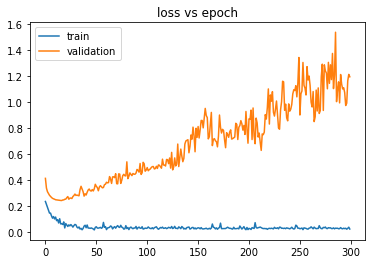

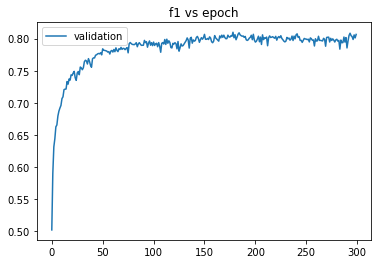

In [20]:
plt.plot(epochs, train_losses, label = "train")
plt.plot(epochs, validation_losses, label = "validation")
plt.legend()
plt.title("loss vs epoch")
plt.savefig(f'trained_models_pics_{model.cnn_name}_loss.png', format = 'png')
plt.show()


plt.plot(epochs, f1_scores_validations, label = "validation")
plt.legend()
plt.title("f1 vs epoch")
#plt.savefig(join("trained_models_pics", model.cnn_name + '_loss.png'), format = 'png')
plt.show()

dict_path = join("trained_models", model.cnn_name + "_state.pt")
torch.save(model.state_dict(), dict_path)
model.save_cnn_params()

We save all the parameters used in the CNN (weights of all the layers and the configurations of the CNN)

## 4. Evaluation of the CNN results

We extract the labels true labels from the training and testing data sets and predict the labels using both labels. The predictions are usually refered as y_hat. 

In [21]:
model.eval()

y_train = train_dataset.labels_tensor

y_validation = validation_dataset.labels_tensor

x_train = PPD.collate_data(train_dataset)[0]
print(x_train)

x_validation = PPD.collate_data(validation_dataset)[0]
print(x_validation)
y_hat_train = model(x_train)

y_hat_validation = model(x_validation)

tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])
tensor([[[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0]]])


We now show how the F1 score changes for all possible thresholds

2103.0 Labels T
1575 Segments T
523.0 Labels V
393 Segments V


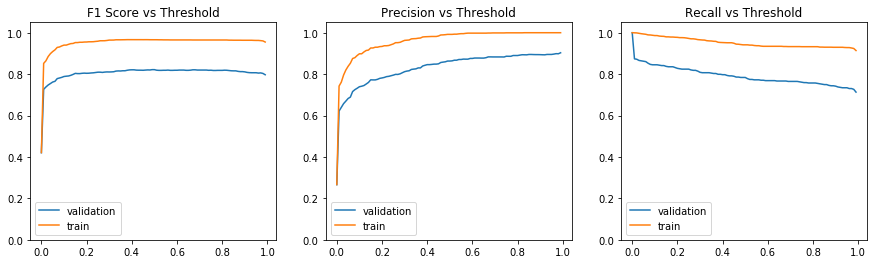

Scores with 0.5 threshold
---------------------------------------------------------------------------------------------------------
f1 micro        |0.8216433525085449
precision micro |0.8631578683853149
recall micro    |0.7839388251304626
---------------------------------------------------------------------------------------------------------
f1 macro        |0.6947675943374634
precision macro |0.8026726841926575
recall macro    |0.6365222930908203
---------------------------------------------------------------------------------------------------------

Score per label with 0.5 threshold
---------------------------------------------------------------------------------------------------------
Label                                           F1        Precision Recall    Count T.  Count V.  
---------------------------------------------------------------------------------------------------------
Collect on first party website/app              0.74      0.74      0.75      0.21      0.19 

<Figure size 432x288 with 0 Axes>

In [22]:
model.print_results(train_dataset, validation_dataset, 0.5)

With the following block of code we will find the threshold that with which we obtain the best overall F1 score. 

In [23]:
best_f1_score, best_threshold_label = CNN.get_best_thresholds(y_validation, y_hat_validation, labels, current_num_levels)

In [24]:
model.print_results_best_t(validation_dataset, torch.tensor(best_threshold_label).float())

Label                                           F1        Precision Recall    
---------------------------------------------------------------------------------------------------------
Collect on first party website/app              0.75      0.8       0.71      
Receive/Shared with                             0.93      0.93      0.93      
See                                             0.69      0.75      0.64      
Track on first party website/app                0.75      0.84      0.68      
Unspecified                                     0.48      0.75      0.35      
macro averages
F1: 0.7171861529350281
Precision: 0.8122831583023071
Recall: 0.6579123735427856


In [25]:
model.f1_score(y_validation, y_hat_validation, torch.tensor(best_threshold_label).float(), macro=True)

(0.7171861529350281, 0.8122831583023071, 0.6579123735427856)

In [26]:
model.f1_score(y_validation, y_hat_validation, torch.tensor(best_threshold_label).float(), macro=False)

(0.8309858441352844, 0.8768577575683594, 0.7896749377250671)

In [567]:
metrics_05 = confusion_matrices(model, validation_dataset, 0.5)

In [568]:
metrics_best_t = confusion_matrices(model, validation_dataset, torch.tensor(best_threshold_label).float())

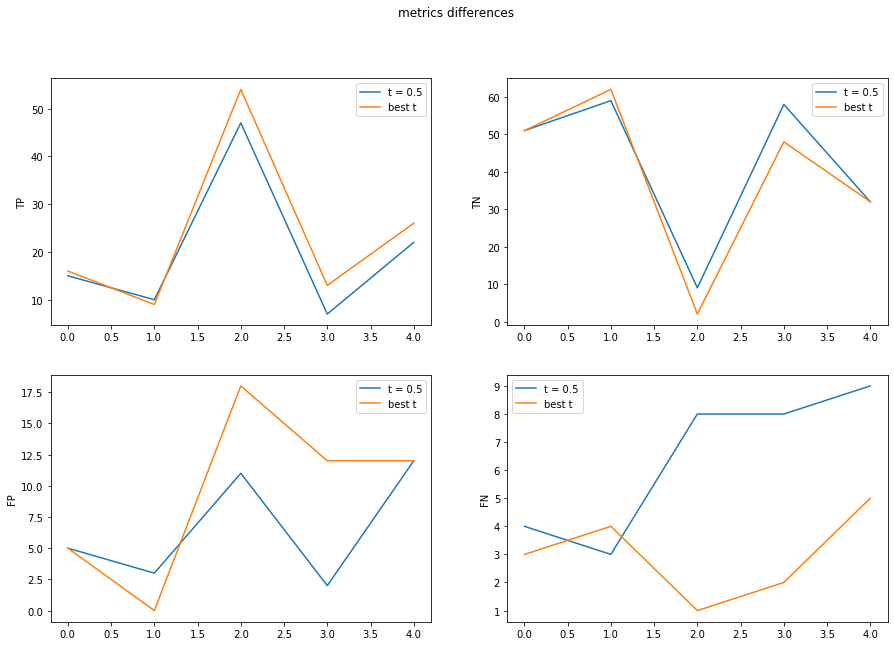

In [32]:
confusion_matrices_change(metrics_05, metrics_best_t)

Now we show the results for the best combination of thresholds

In [33]:
# We show the F1, precision and recall for the best threshold
#f1, precision, recall = CNN.f1_score(y_validation, y_hat_validation, torch.tensor(best_t_label).float())
f1, precision, recall = CNN.f1_score_per_label(y_validation, y_hat_validation, 0.5)

print("f1        |" + str(f1))

print("precision |" + str(precision))

print("recall    |" + str(recall))

f1        |tensor([0.7692, 0.7692, 0.8319, 0.5833, 0.6769])
precision |tensor([0.7500, 0.7692, 0.8103, 0.7778, 0.6471])
recall    |tensor([0.7895, 0.7692, 0.8545, 0.4667, 0.7097])


We show a list of all the possible labels to remind the user which ones are available.

In [34]:
for label, i in labels.items():
    
    print("index {}. {}.".format(i, label))

index 0. Profile data.
index 1. Transactional data.
index 2. User account data.
index 3. Other data about user.
index 4. Unspecified.


We can also show how the F1 score changes for all possible thresholds in just one label

In [35]:
threshold_list = np.arange(0.0, 1, 0.01)

label = 'Children'

f1_scores_per_label = [CNN.f1_score_per_label(y_validation, y_hat_validation, t)[0][labels[label]].item() for t in threshold_list]

plt.plot(threshold_list, f1_scores_per_label)

plt.title(label + " f1 score" + " vs threshold")

plt.show()

f1_label, precision_label, recall_label = CNN.f1_score_per_label(y_validation, y_hat_validation, 0.5)

f1_label = f1_label[labels[label]].item()

precision_label = precision_label[labels[label]].item()

recall_label = recall_label[labels[label]].item()

print("Label: " + label + "\n")

print("f1_label        |" + str(f1_label))

print("precision_label |" + str(precision_label))

print("recall_label    |" + str(recall_label))

KeyError: 'Children'

## 5. Comparison between models

In [38]:
folder = 'trained_models/Thresholds'

files = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and '.pt' in f]

In [39]:
files

[]

In [41]:
params_model1_file = open('trained_models/cnn_100_200_[100]_12_[3]_e80_60-20-20_polisis_params.pkl', 'rb')

params_model1 = pickle.load(params_model1_file)

FileNotFoundError: [Errno 2] No such file or directory: 'trained_models/cnn_100_200_[100]_12_[3]_e80_60-20-20_polisis_params.pkl'

In [35]:
model1 = CNN(**params_model1)

model1.load_state_dict(torch.load('trained_models/Thresholds/cnn_300_200_[100]_12_[3]_e80_60-20-20_polisis_state.pt'))

model1.print_results(train_dataset, validation_dataset, 0.5)

y_validation = validation_dataset.labels_tensor

x_validation = PPD.collate_data(validation_dataset)[0]

y_hat_validation1 = model1(x_validation)

NameError: name 'params_model1' is not defined

In [36]:
best_f1_score1, best_t_label1 = CNN.get_best_thresholds(y_validation, y_hat_validation1, labels)

model1.print_results_best_t(validation_dataset, torch.tensor(best_t_label1).float())

print('----macro averages----')

model1.f1_score(y_validation, y_hat_validation1, torch.tensor(best_t_label1).float(), macro=True)

NameError: name 'y_hat_validation1' is not defined

In [37]:
metrics = confusion_matrices(model1, validation_dataset, torch.tensor(best_t_label1).float())

tp = sum(metrics['TP'])
fp = sum(metrics['FP'])
tn = sum(metrics['TN'])
fn = sum(metrics['FN'])

print('------------------best_t--------------------')

print('f1: {}'.format(2 * tp / (2 * tp + fn + fp)))
print('precision: {}'.format(tp / (tp + fp)))
print('recall: {}'.format(tp / (tp + fn)))

metrics = confusion_matrices(model1, validation_dataset, torch.tensor(0.5).float())

tp = sum(metrics['TP'])
fp = sum(metrics['FP'])
tn = sum(metrics['TN'])
fn = sum(metrics['FN'])

print('-------------------t-0.5--------------------')

print('f1: {}'.format(2 * tp / (2 * tp + fn + fp)))
print('precision: {}'.format(tp / (tp + fp)))
print('recall: {}'.format(tp / (tp + fn)))

NameError: name 'model1' is not defined

In [ ]:
params_model2_file = open('trained_models/Thresholds/cnn_300_200_[100]_12_[3]_lr.005_e300_60-20-20_polisis_params.pkl', 'rb')

params_model2 = pickle.load(params_model2_file)

In [ ]:
model2 = CNN(**params_model2)

model2.load_state_dict(torch.load('trained_models/Thresholds/cnn_300_200_[100]_12_[3]_lr.005_e300_60-20-20_polisis_state.pt'))

model2.print_results(train_dataset, validation_dataset, 0.5)

y_validation = validation_dataset.labels_tensor

x_validation = PPD.collate_data(validation_dataset)[0]

y_hat_validation2 = model2(x_validation)

In [ ]:
best_f1_score, best_t_label2 = CNN.get_best_thresholds(y_validation, y_hat_validation2, labels)

model2.print_results_best_t(validation_dataset, torch.tensor(best_t_label2).float())

print('----macro averages----')

model2.f1_score(y_validation, y_hat_validation2, torch.tensor(best_t_label2).float(), macro=True)

In [ ]:
metrics = confusion_matrices(model2, validation_dataset, torch.tensor(best_t_label2).float())

tp = sum(metrics['TP'])
fp = sum(metrics['FP'])
tn = sum(metrics['TN'])
fn = sum(metrics['FN'])

print('------------------best_t--------------------')

print('f1: {}'.format(2 * tp / (2 * tp + fn + fp)))
print('precision: {}'.format(tp / (tp + fp)))
print('recall: {}'.format(tp / (tp + fn)))

metrics = confusion_matrices(model2, validation_dataset, torch.tensor(0.5).float())

tp = sum(metrics['TP'])
fp = sum(metrics['FP'])
tn = sum(metrics['TN'])
fn = sum(metrics['FN'])

print('-------------------t-0.5--------------------')

print('f1: {}'.format(2 * tp / (2 * tp + fn + fp)))
print('precision: {}'.format(tp / (tp + fp)))
print('recall: {}'.format(tp / (tp + fn)))

In [ ]:
model2.f1_score_per_label(y_validation, y_hat_validation2, torch.tensor(best_t_label2).float())